<a href="https://colab.research.google.com/github/CIT-NLP/NLP-final-project/blob/main/XGBoostwithSMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown https://drive.google.com/uc?id=1gRM0y476quq727mTJJpE2B-42g7OhtaK

Downloading...
From: https://drive.google.com/uc?id=1gRM0y476quq727mTJJpE2B-42g7OhtaK
To: /content/data.csv
100% 209M/209M [00:00<00:00, 213MB/s]


In [ ]:
import pandas as pd
from ast import literal_eval

df = pd.read_csv("./data.csv")

# interpret cols as lists instead of strings
for col in ['unigrams', 'sentences', 'lem_sent', 'lem_sent_join']: 
  df[col] = df[col].apply(literal_eval)

df

,summary,unigrams,sentences,lem_sent,lem_sent_join,genre
0,A series of murders of rich young women throug...,"[series, murder, rich, young, woman, arizona, ...",[A series of murders of rich young women throu...,"[[series, murder, rich, young, woman, arizona,...",[series murder rich young woman arizona bear d...,thriller
1,"Eva, an upper class housewife, becomes frustra...","[eva, upper, class, housewife, frustrated, lea...","[Eva, an upper class housewife, becomes frustr...","[[eva, upper, class, housewife, frustrated, le...",[eva upper class housewife frustrated leave ar...,drama
2,"Adam, a San Francisco-based artist who works a...","[adam, san, francisco, base, artist, work, cab...","[Adam, a San Francisco-based artist who works ...","[[adam, san, francisco, base, artist, work, ca...",[adam san francisco base artist work cab drive...,drama
3,The film opens with a simpleton from a small v...,"[film, open, simpleton, small, village, tamil,...",[The film opens with a simpleton from a small ...,"[[film, open, simpleton, small, village, tamil...",[film open simpleton small village tamil nadu ...,romance
4,"Professor Kurian Fernandez , a convict escapes...","[professor, kurian, fernandez, convict, escape...","[Professor Kurian Fernandez , a convict escape...","[[professor, kurian, fernandez, convict, escap...",[professor kurian fernandez convict escape jai...,action
...,...,...,...,...,...,...
17488,"The space armada from Mars, known as the Imper...","[space, armada, mars, know, imperial, atomic, ...","[The space armada from Mars, known as the Impe...","[[space, armada, mars, know, imperial, atomic,...",[space armada mars know imperial atomic space ...,comedy
17489,Kalai Arasi' is a well-blended story of romanc...,"[kalai, arasi, blend, story, romance, science,...",[Kalai Arasi' is a well-blended story of roman...,"[[kalai, arasi, blend, story, romance, science...",[kalai arasi blend story romance science ficti...,romance
17490,Havoc is wrought on the inhabitants of a small...,"[havoc, work, inhabitant, small, new, england,...",[Havoc is wrought on the inhabitants of a smal...,"[[havoc, work, inhabitant, small, new, england...",[havoc work inhabitant small new england town ...,comedy
17491,After accidentally causing the death of his pa...,"[accidentally, cause, death, partner, hostage,...",[After accidentally causing the death of his p...,"[[accidentally, cause, death, partner, hostage...",[accidentally cause death partner hostage situ...,horror


## Doc2Vec

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


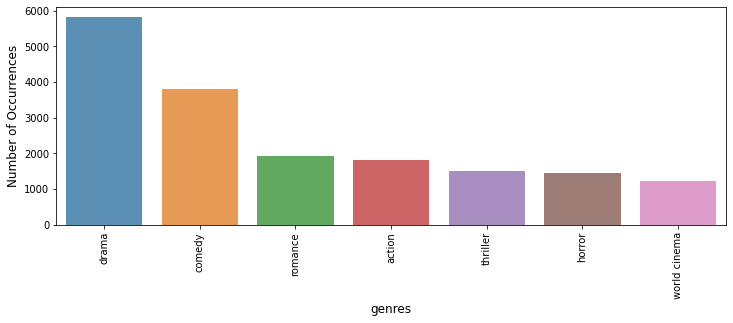

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cnt_pro = df['genre'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('genres', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:
from sklearn.model_selection import train_test_split
import gensim
from gensim.models.doc2vec import TaggedDocument

train, test = train_test_split(df, test_size=0.2, random_state=42)
train_tagged = train.apply(lambda r: TaggedDocument(words=r['unigrams'], tags=r.genre), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=r['unigrams'], tags=r.genre), axis=1)

train_tagged.values[0].tags

'drama'

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

2

In [ ]:
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 13994/13994 [00:00<00:00, 1465179.49it/s]


In [ ]:
from sklearn import utils

for epoch in range(5):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 13994/13994 [00:00<00:00, 3212824.47it/s]


In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags, model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [ ]:
import numpy as np

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [ ]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state = 0)
os_smote_X,os_smote_Y = os.fit_resample(X_train, y_train)


print(X_train.shape)

print(os_smote_X.shape)

(13994, 100)
(32655, 100)


In [ ]:
import xgboost 
from xgboost import XGBClassifier

xgb = XGBClassifier().fit(os_smote_X, os_smote_Y)
y_pred = xgb.predict(X_test)

In [ ]:
y_pred

array(['drama', 'drama', 'drama', ..., 'drama', 'drama', 'drama'],
      dtype='<U12')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.3758216633323807
Testing F1 score: 0.3799852652904607


In [ ]:
y_pred[:1000]